In [1]:
suppressMessages(library(fable))
suppressMessages(library(forecast))
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(scales))
suppressMessages(library(feasts))
suppressMessages(library(magrittr))
suppressMessages(library(tsibble))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))
suppressMessages(library(tidyr))

# Reading the data

In [2]:
cpi <- read.csv('CPILFESL.csv')

In [3]:
yoy <- cpi |>
rename(CPI = CPILFESL) |>
mutate(ChangeYoy = CPI/lag(CPI,n = 12)-1) |>
mutate(DATE = yearmonth(as.Date(DATE))) |>
filter(!is.na(ChangeYoy)) %>%
as_tsibble(index = DATE)

yoy |> head(1)

DATE,CPI,ChangeYoy
<mth>,<dbl>,<dbl>
1958 Jan,29.3,0.02807018


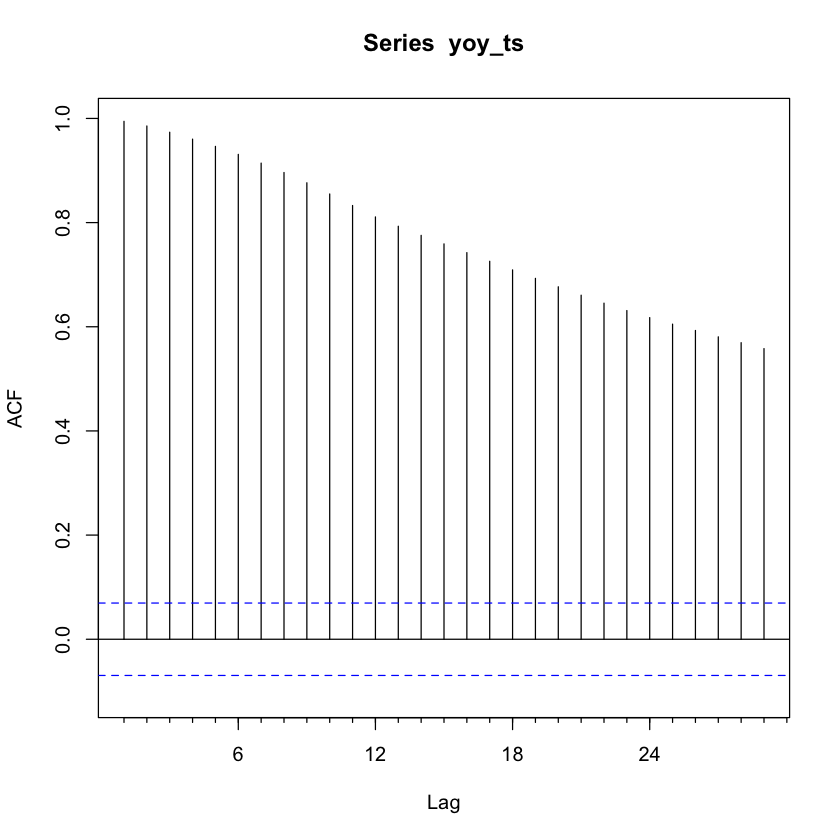

In [4]:
yoy_ts <- ts(yoy$ChangeYoy,start=c(1958,1), frequency = 12)
Acf(yoy_ts)

Model not specified, defaulting to automatic modelling of the `value` variable. Override this using the model formula.


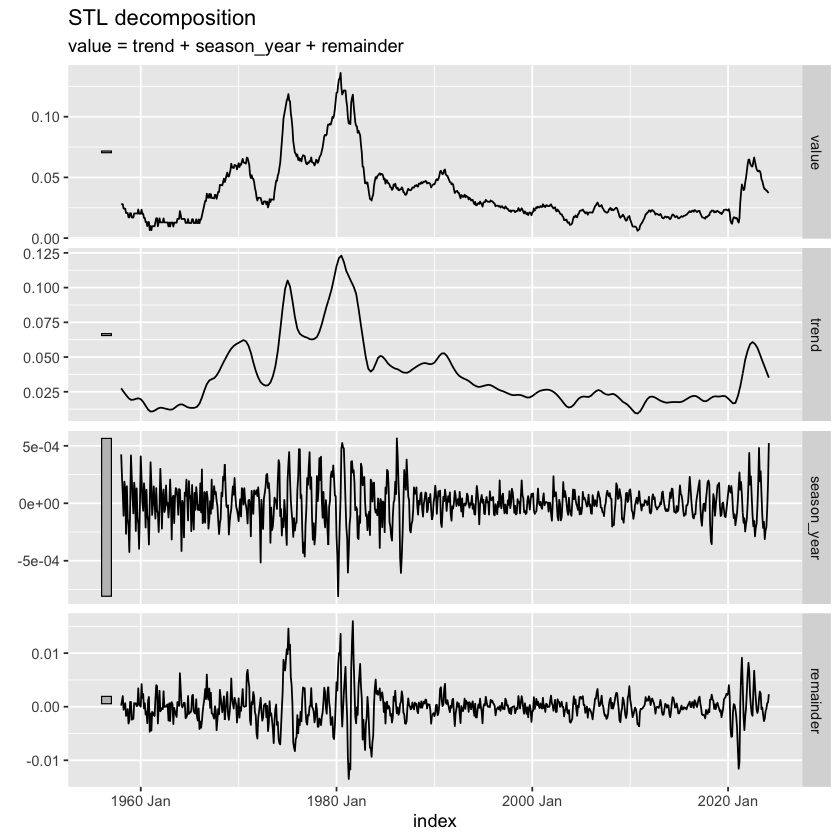

In [5]:
sa <- yoy_ts |>
 as_tsibble(index=DATE) |>
model(STL())

sa |> components() |> autoplot()

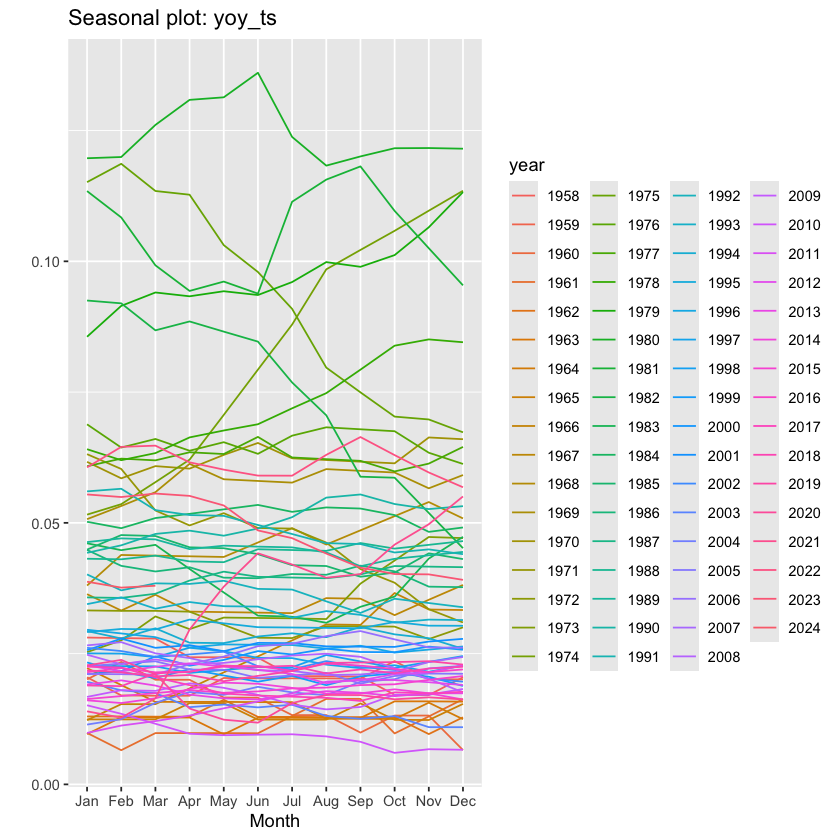

In [6]:
yoy_ts |> ggseasonplot()

Data has more cyclic nature and no clear seasonality

# Data Summary:
Data shows cycles but lacks clear Seasonality and Trend, and it ranges from 0% to 13% in scale.

# Stationarity Check

In [7]:
yoy_ts |> as_tsibble(index= DATE) |> features(value,unitroot_kpss)

kpss_stat,kpss_pvalue
<dbl>,<dbl>
2.159622,0.01


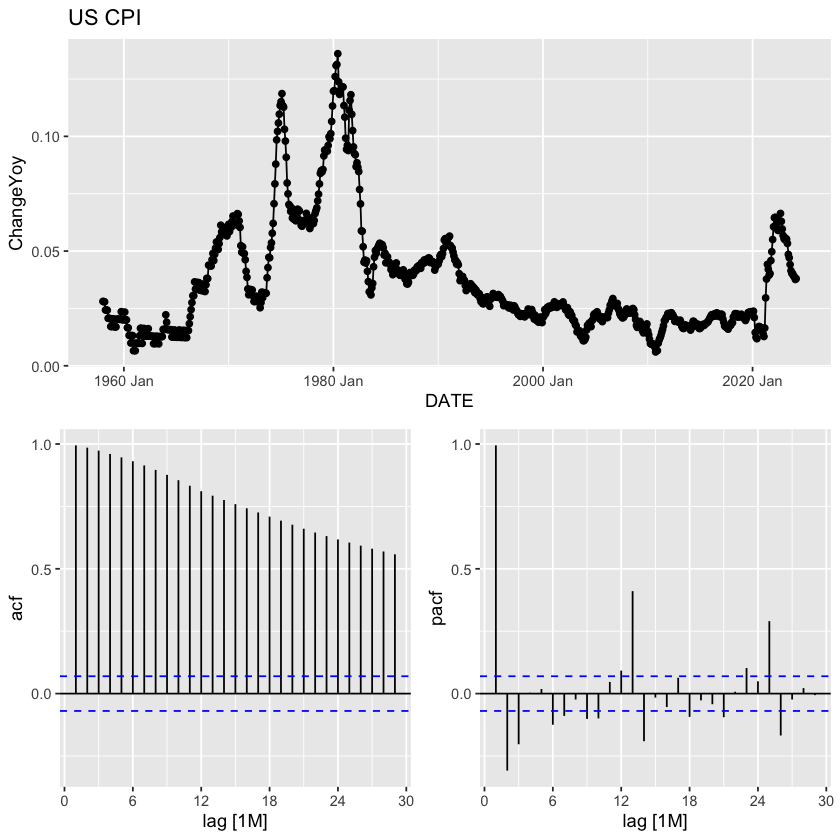

In [8]:
yoy |> gg_tsdisplay(ChangeYoy, plot_type = 'partial') + labs(title='US CPI')

In [9]:
yoy |> features(ChangeYoy, unitroot_ndiffs)

ndiffs
<int>
1


From the unitroot calculation no of differences = 1 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


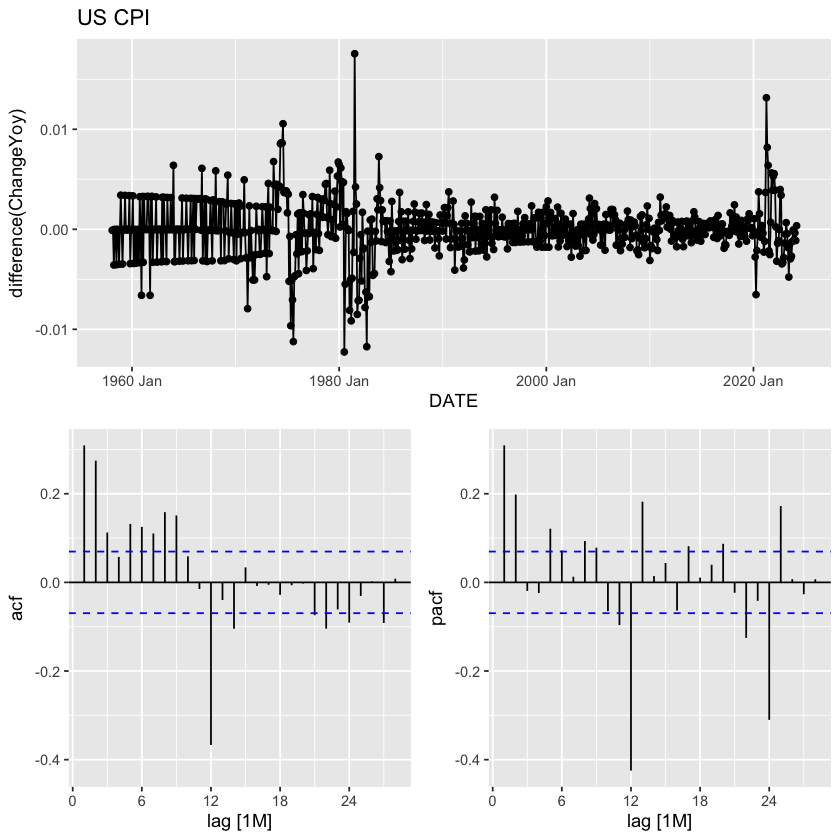

In [10]:
yoy |> gg_tsdisplay(difference(ChangeYoy), plot_type = 'partial') + labs(title='US CPI')

kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.05682118,0.1


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


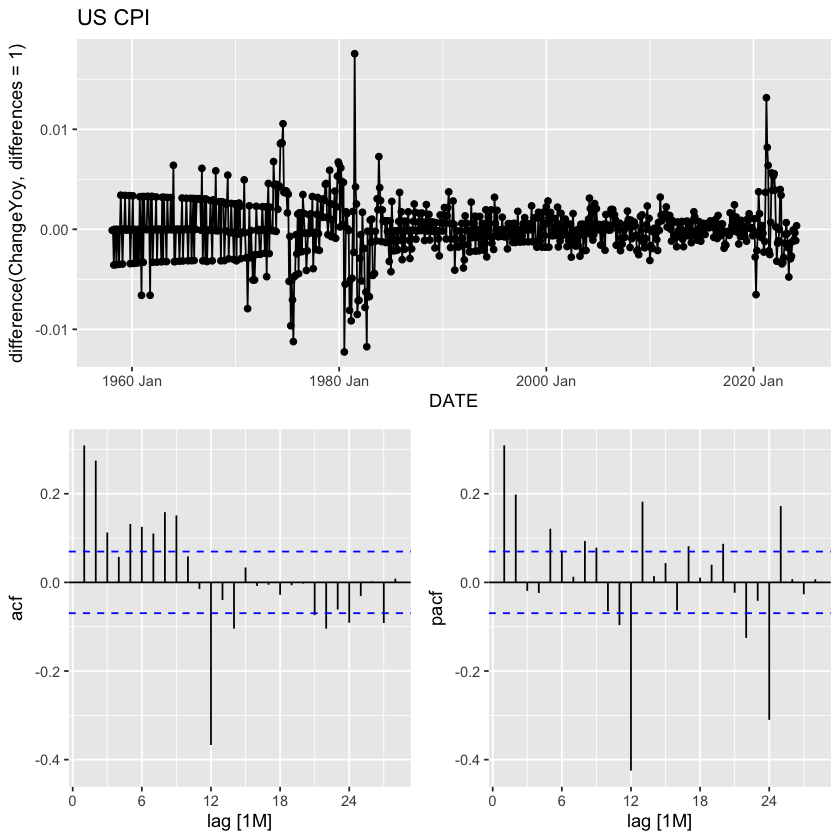

In [11]:
#differencing
yoy_ts |> diff(differences = 1) |> as_tsibble(index= DATE) |> features(value,unitroot_kpss)
yoy |> gg_tsdisplay(difference(ChangeYoy,differences = 1), plot_type = 'partial') + labs(title='US CPI')


<b>p,d,q determination:</b><br>
Null hypothesis for kpss unit root test is false hence it is stationary at Order =1  <br> 

From ACF and PACF plots we can see that<br>
(p,d,q)=(2,1,3)


kpss_stat,kpss_pvalue
<dbl>,<dbl>
0.0952379,0.1


Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


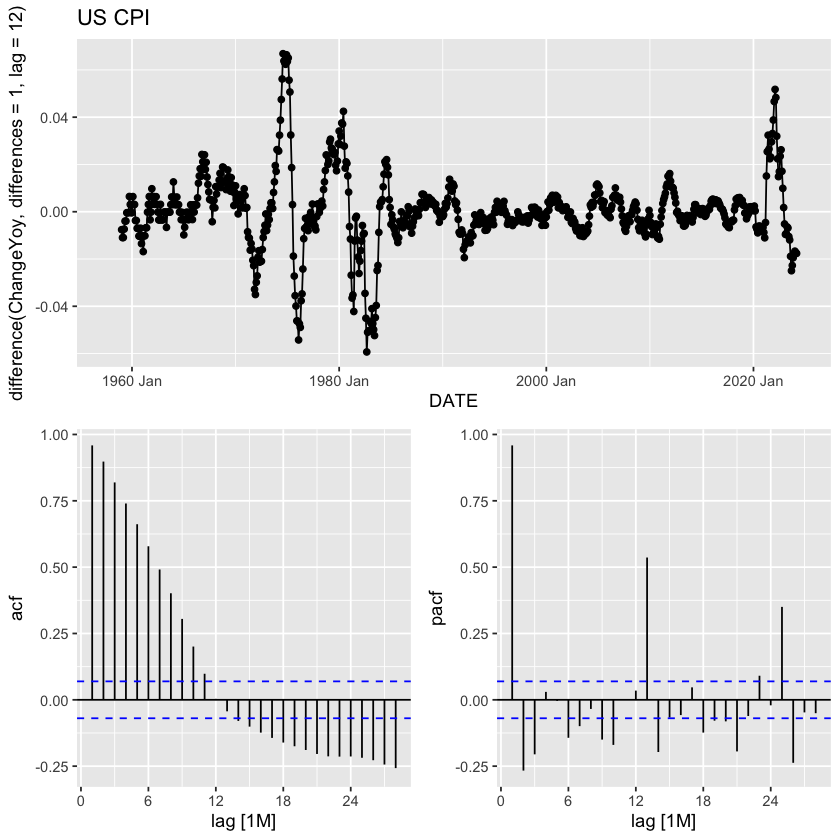

In [12]:
#seasonal differencing
yoy_ts |> diff(differences = 1,lag = 12) |> as_tsibble(index= DATE) |> features(value,unitroot_kpss)
yoy |> gg_tsdisplay(difference(ChangeYoy,differences = 1,lag = 12), plot_type = 'partial') + labs(title='US CPI')

<b>Seasonal Arima Terms </b> <br>
Since there is no seasonality I seasonal ARIMA is not selected<br>
(P,D,Q) = (0,0,0)

# Modeling ARIMA

In [13]:
arima_manual <- yoy |> model(ARIMA(ChangeYoy ~ 0 + pdq(2:3,1:2,1:3)+PDQ(0,0,0))) 
arima_manual %>% report()

Series: ChangeYoy 
Model: ARIMA(2,1,1) 

Coefficients:
         ar1     ar2     ma1
      0.1808  0.2185  0.0695
s.e.  0.1442  0.0540  0.1464

sigma^2 estimated as 5.967e-06:  log likelihood=3650.39
AIC=-7292.78   AICc=-7292.72   BIC=-7274.07


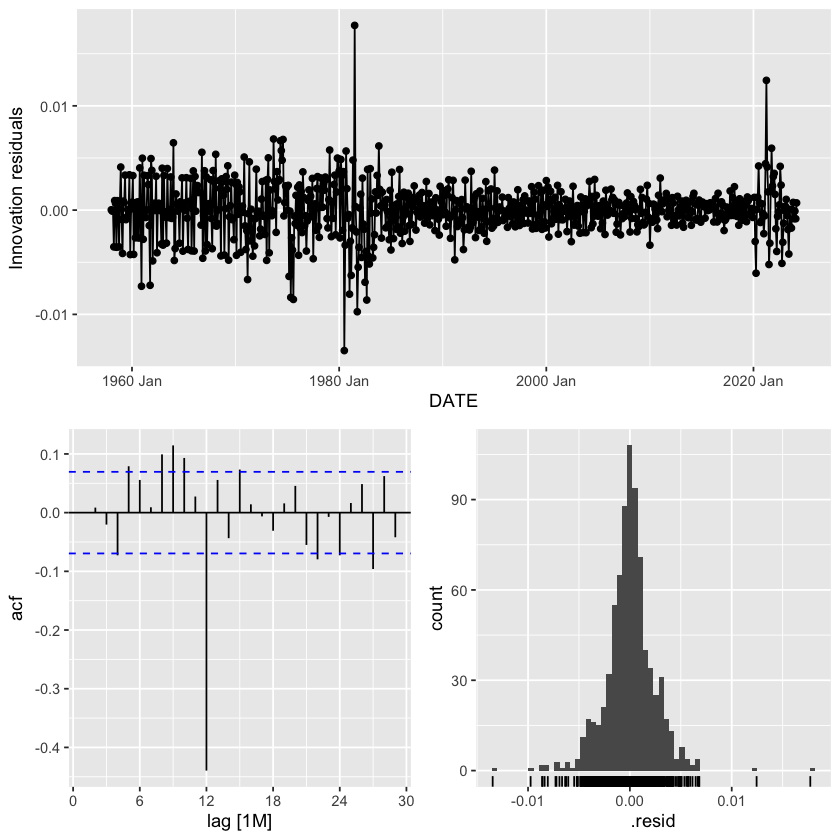

In [14]:
#Residuals
arima_manual |> gg_tsresiduals()

In [15]:
arima_auto <- yoy %>% model(ARIMA(ChangeYoy)) 
arima_auto %>% report()

Series: ChangeYoy 
Model: ARIMA(1,1,1)(2,0,2)[12] 

Coefficients:
         ar1      ma1    sar1     sar2     sma1    sma2
      0.9888  -0.7594  0.5646  -0.0811  -1.6413  0.6708
s.e.  0.0060   0.0260  0.1463   0.0460   0.1447  0.1415

sigma^2 estimated as 2.943e-06:  log likelihood=3916.88
AIC=-7819.76   AICc=-7819.61   BIC=-7787.02


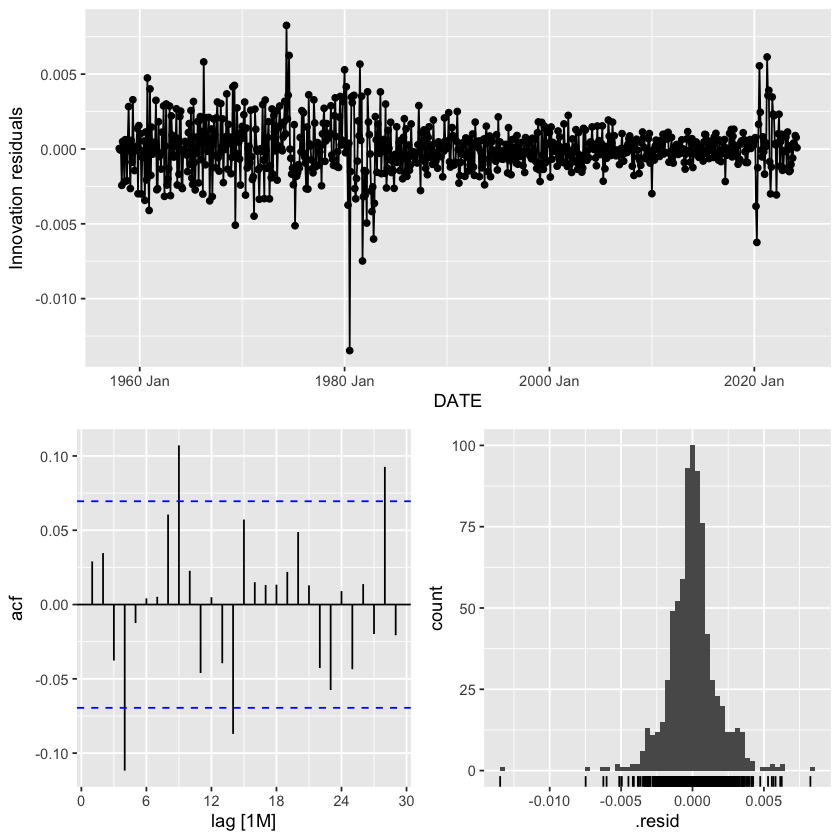

In [16]:
arima_auto |> gg_tsresiduals()

Auto Arima with terms (1,1,1)(2,0,2) performed better than estimated one

In [17]:
training <- yoy %>% filter_index(. ~ 'Feb 2023')
test <- yoy %>% filter_index('Mar 2023' ~ .)

In [18]:
models <- training |>
model(
    'ETS' = ETS(ChangeYoy),
    'ARIMA' = ARIMA(ChangeYoy),
    'NAIVE' = NAIVE(ChangeYoy)
)

In [19]:
models %>% report()

Warning message in report.mdl_df(.):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,sigma2,log_lik,AIC,AICc,BIC,MSE,AMSE,MAE,ar_roots,ma_roots
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<list>
ETS,6.096767e-06,2092.754,-4173.508,-4173.399,-4145.537,6.057785e-06,1.699872e-05,0.001690847,NULL,NULL
ARIMA,2.982817e-06,3847.909,-7679.818,-7679.631,-7642.533,NA,NA,NA,"0.5655031+0.9794801i, -0.9794801+0.5655031i, -0.5466663-0.9468539i, 1.0102792-0.0000000i, -0.9468539+0.5466663i, 0.0000000-1.0933327i, 1.0933327+0.0000000i, -1.0933327+0.0000000i, 0.0000000-1.1310062i, 0.9468539+0.5466663i, 0.0000000+1.0933327i, -0.9468539-0.5466663i, 0.5655031-0.9794801i, 0.9794801+0.5655031i, -0.5466663+0.9468539i, -0.9794801-0.5655031i, 0.5466663-0.9468539i, 0.5466663+0.9468539i, -0.5655031+0.9794801i, -0.5655031-0.9794801i, 0.9468539-0.5466663i, 0.0000000+1.1310062i, -1.1310062+0.0000000i, 0.9794801-0.5655031i, 1.1310062-0.0000000i","0.5064791+0.8772476i, -0.8772476+0.5064791i, -0.5097445-0.8829033i, 0.8829033-0.5097445i, 0.5097445+0.8829033i, -0.8829033+0.5097445i, 0.0000000-1.0194889i, 1.0129582-0.0000000i, 0.0000000+1.0129582i, -1.0194889-0.0000000i, 0.0000000-1.0129582i, 1.0194889+0.0000000i, 0.0000000+1.0194889i, -0.8829033-0.5097445i, 0.5064791-0.8772476i, 0.8829033+0.5097445i, -0.5064791+0.8772476i, -0.8772476-0.5064791i, 0.5097445-0.8829033i, 0.8772476+0.5064791i, -0.5097445+0.8829033i, -0.5064791-0.8772476i, 0.8772476-0.5064791i, 1.3136295-0.0000000i, -1.0129582+0.0000000i"
NAIVE,6.901835e-06,NA,NA,NA,NA,NA,NA,NA,NULL,NULL


In [20]:
models |> accuracy()

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ETS,Training,1.591555e-05,0.002461257,0.001690847,-0.1632079,5.944312,0.1785925,0.1608273,0.01180351
ARIMA,Training,-2.599762e-06,0.001718226,0.001192768,-0.1922930,4.252365,0.1259838,0.1122751,0.02920673
NAIVE,Training,3.439778e-05,0.002625677,0.001737137,-0.3541975,5.759755,0.1834818,0.1715711,0.30581468


In [21]:
arima_manual |> accuracy()

.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"ARIMA(ChangeYoy ~ 0 + pdq(2:3, 1:2, 1:3) + PDQ(0, 0, 0))",Training,6.982056e-06,0.002436611,0.001695998,-0.2371623,5.943736,0.1772914,0.1590185,0.00090217


# Model Selection

Using the terms determined a pretty close accracy (MAPE) is observed compared to both ETS and ARIMA_Auto, Naive is also very close<br>best model I will consider is Auto Arima

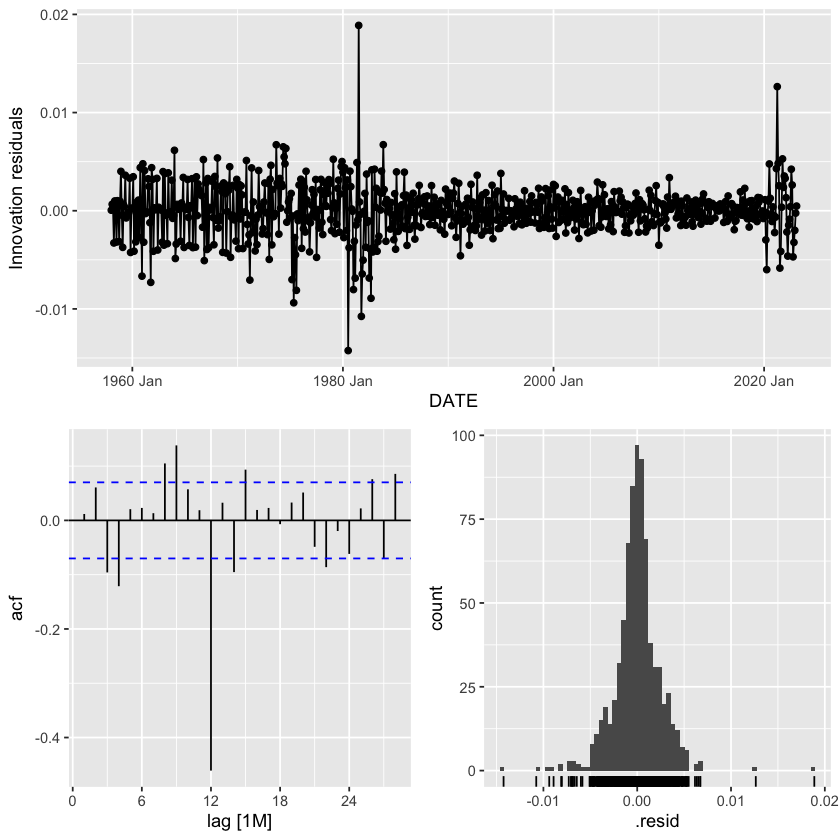

In [22]:
models %>% select(ETS) %>% gg_tsresiduals()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_bin()`).”


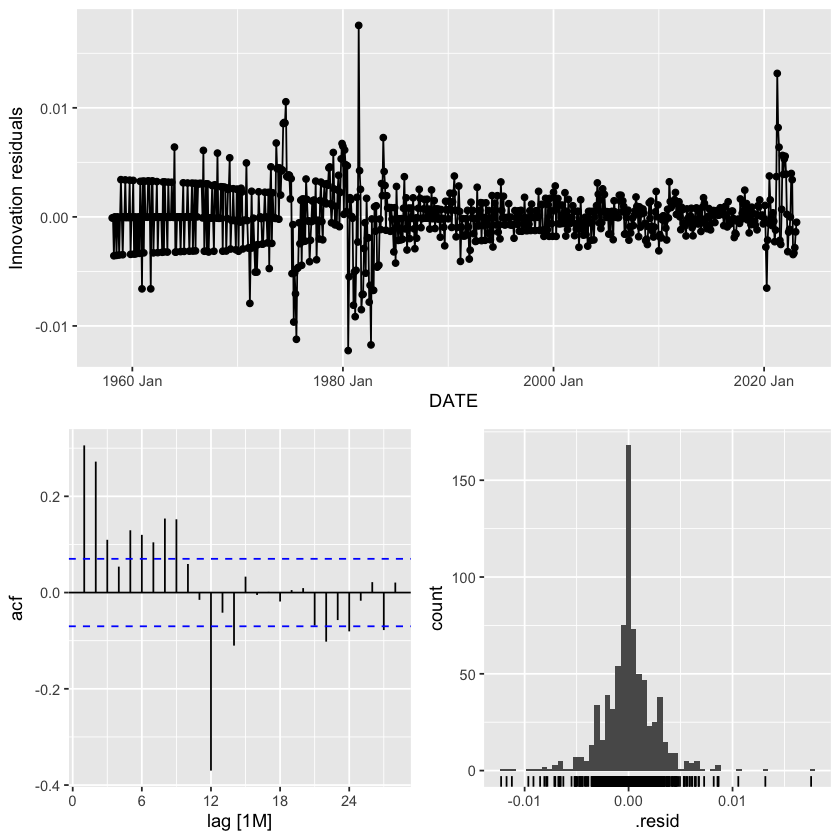

In [23]:
models %>% select(NAIVE) %>% gg_tsresiduals()

# Model Training

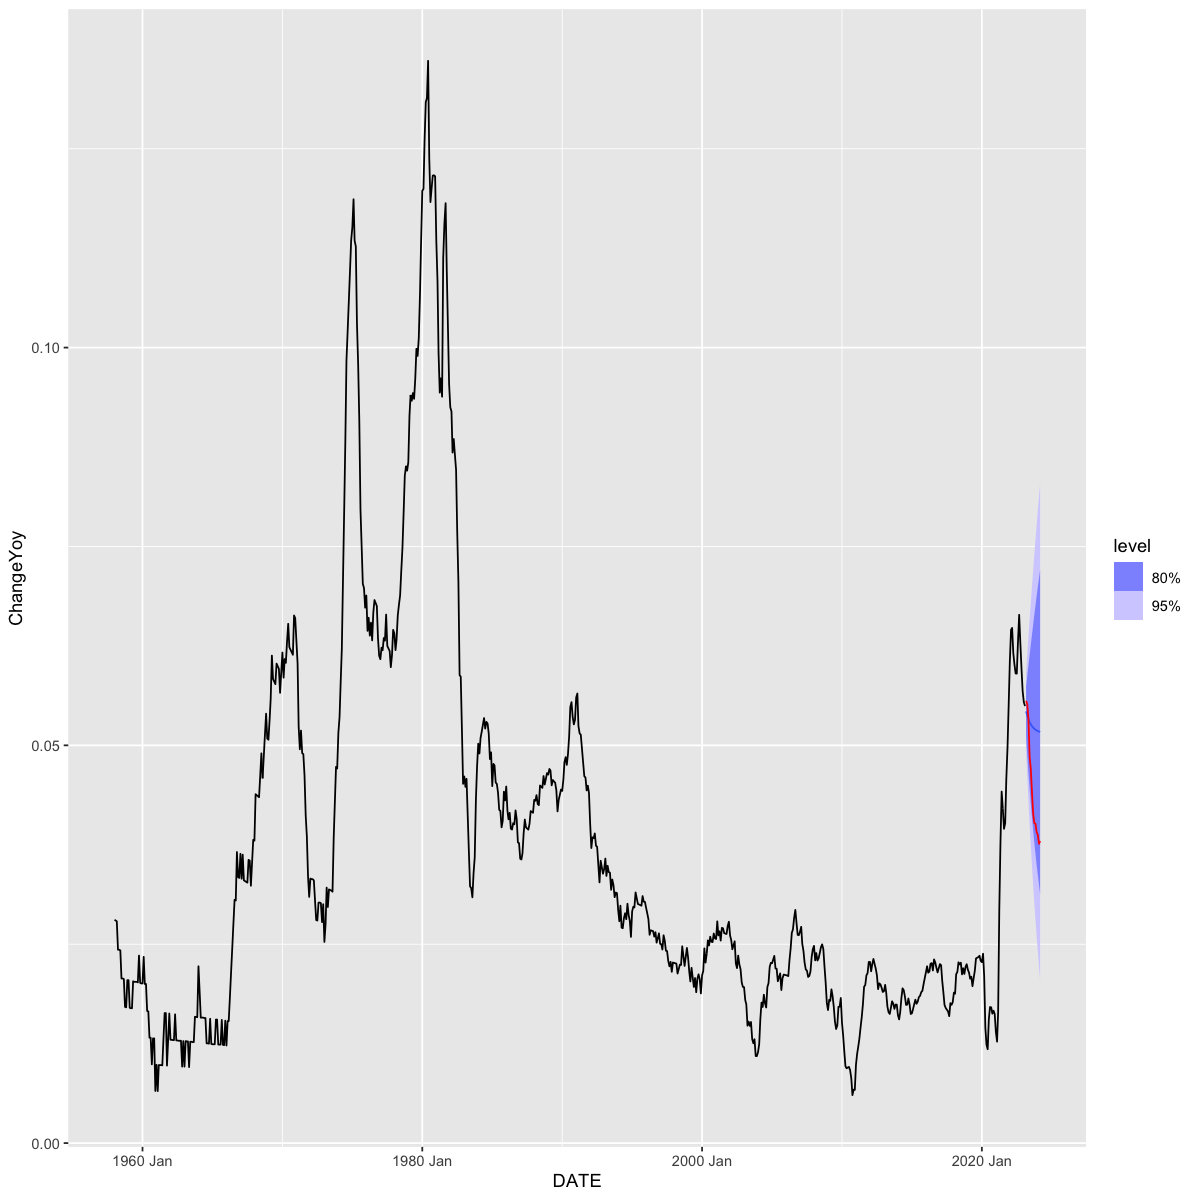

In [24]:
options(repr.plot.width=10, repr.plot.height=10)
models %>% select(ETS) %>% forecast(test) %>% autoplot(training) +
autolayer(test, ChangeYoy, col='red')

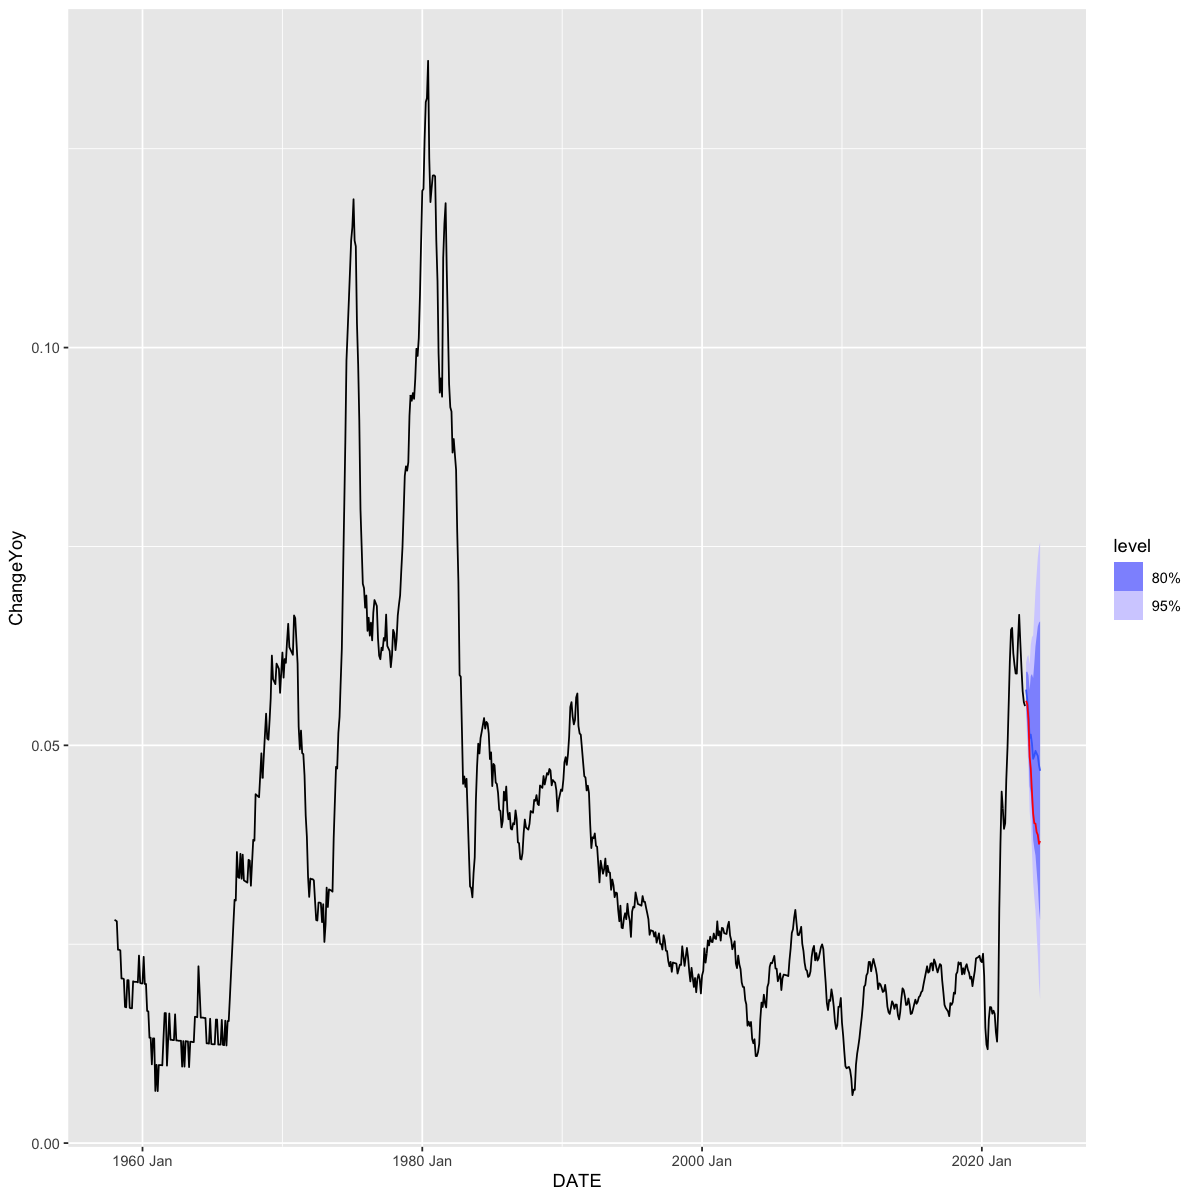

In [25]:
models %>% select(ARIMA) %>% forecast(test) %>% autoplot(training) +
autolayer(test, ChangeYoy, col='red')

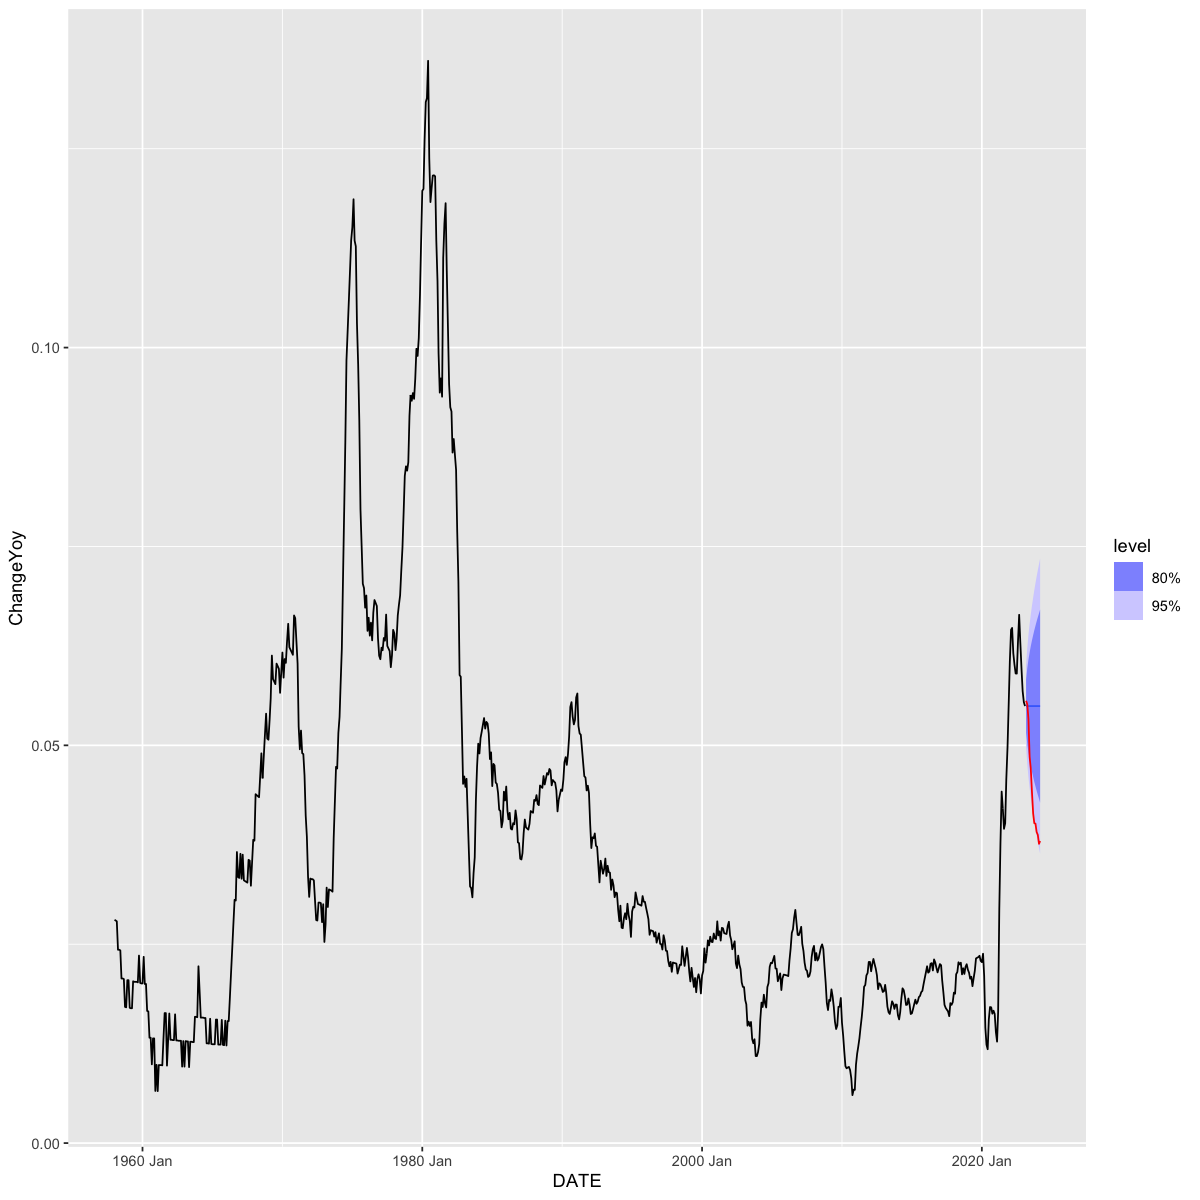

In [26]:
models %>% select(NAIVE) %>% forecast(test) %>% autoplot(training) +
autolayer(test, ChangeYoy, col='red')

# Forecasts

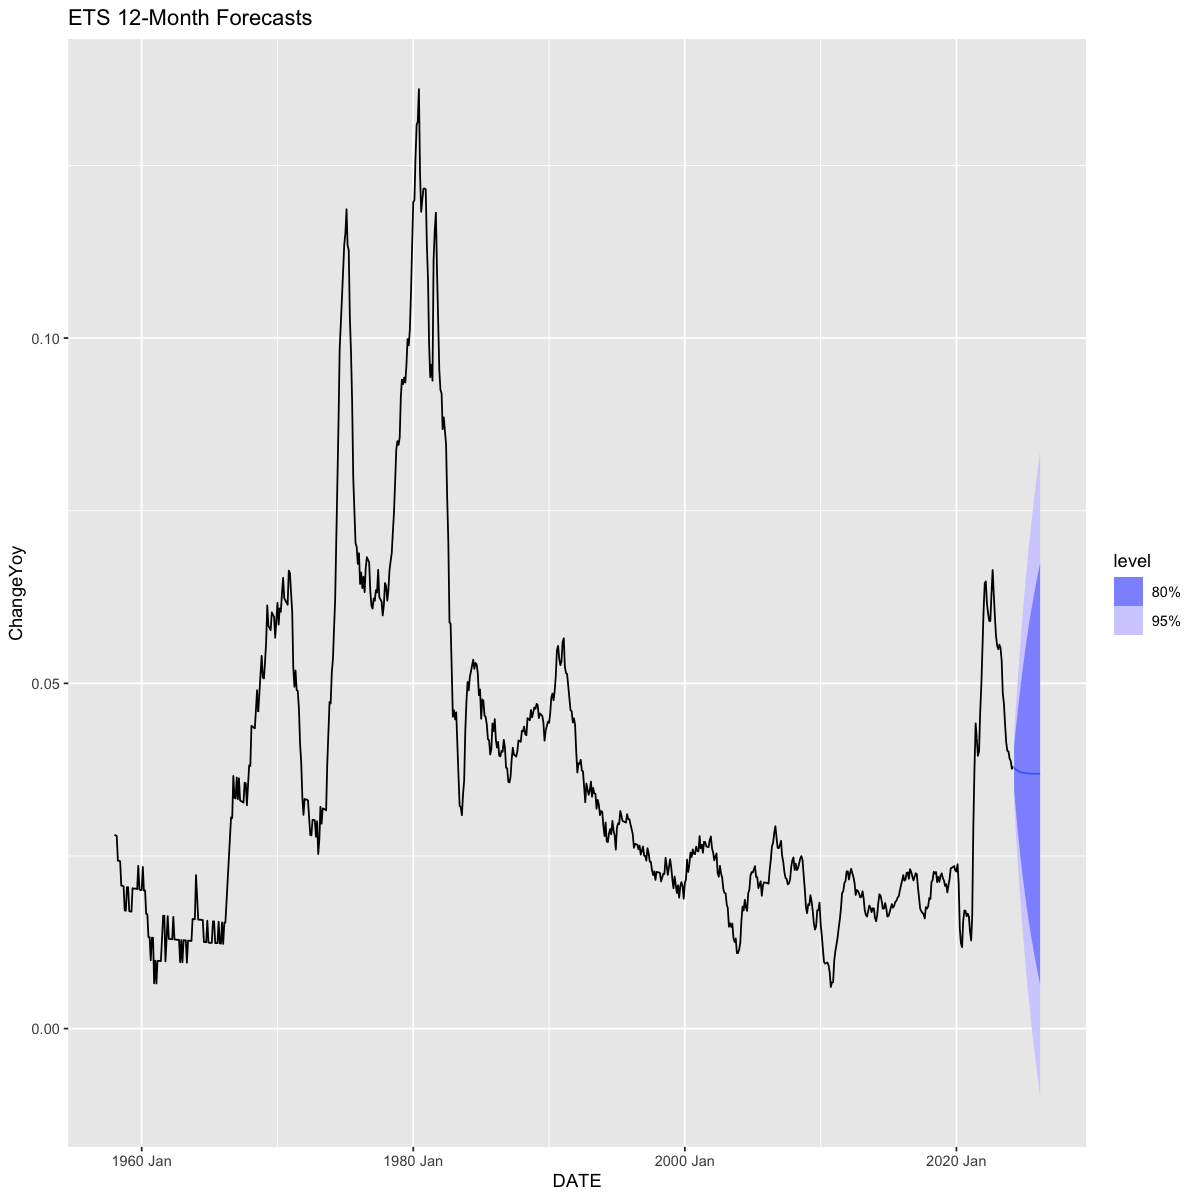

In [27]:
yoy %>% model(ETS(ChangeYoy)) %>% forecast(horizon=12) %>% autoplot(yoy) + labs(title='ETS 12-Month Forecasts')
     

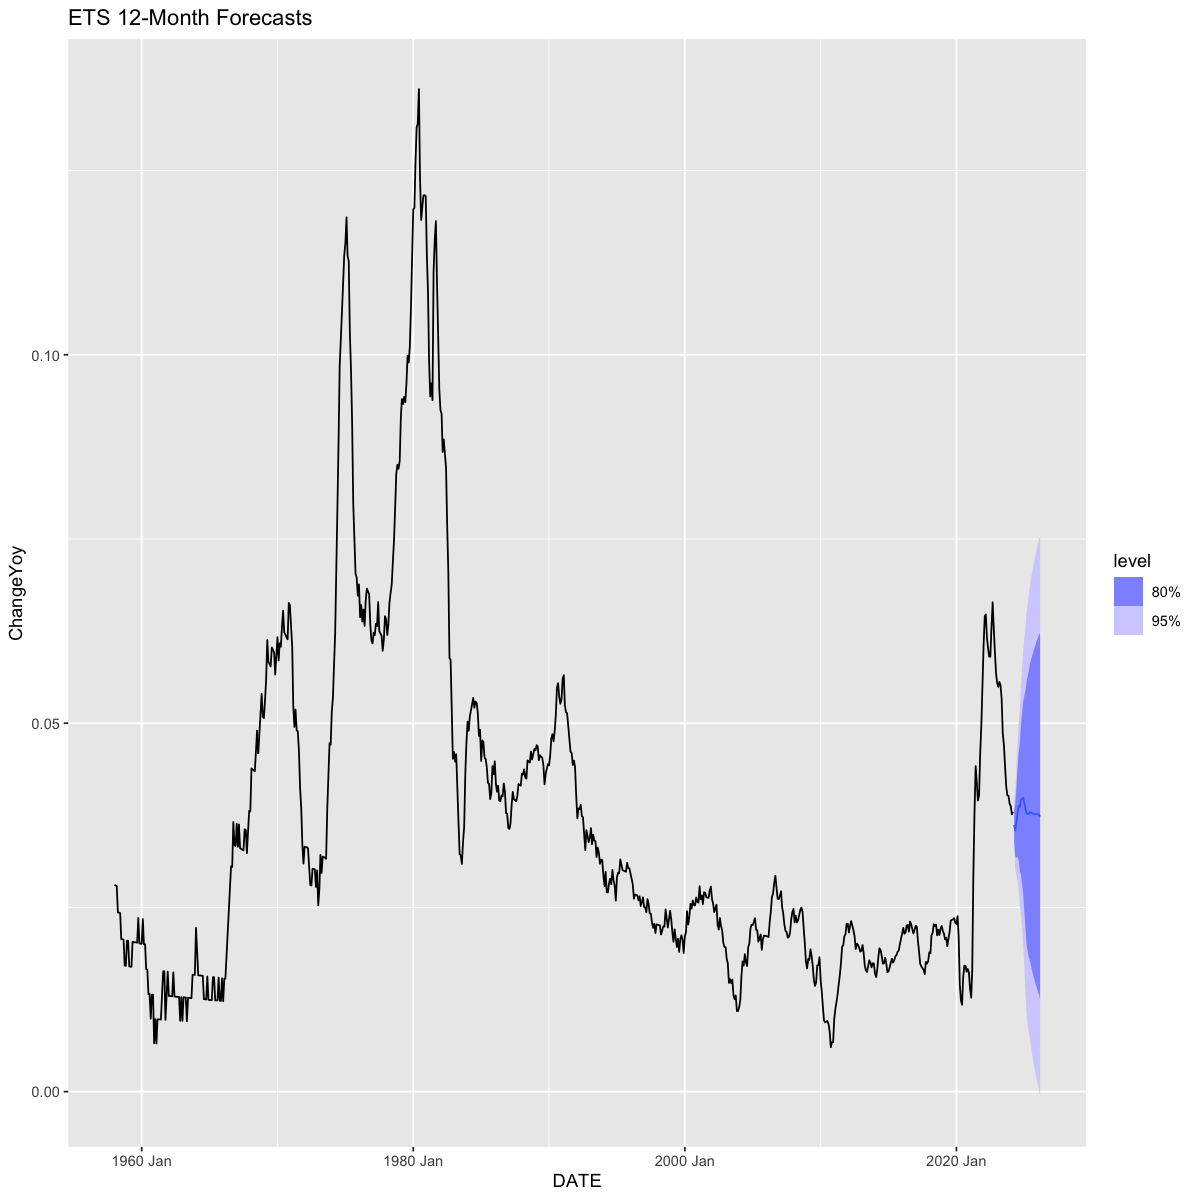

In [28]:
yoy %>% model(ARIMA(ChangeYoy)) %>% forecast(horizon=12) %>% autoplot(yoy) + labs(title='ETS 12-Month Forecasts')

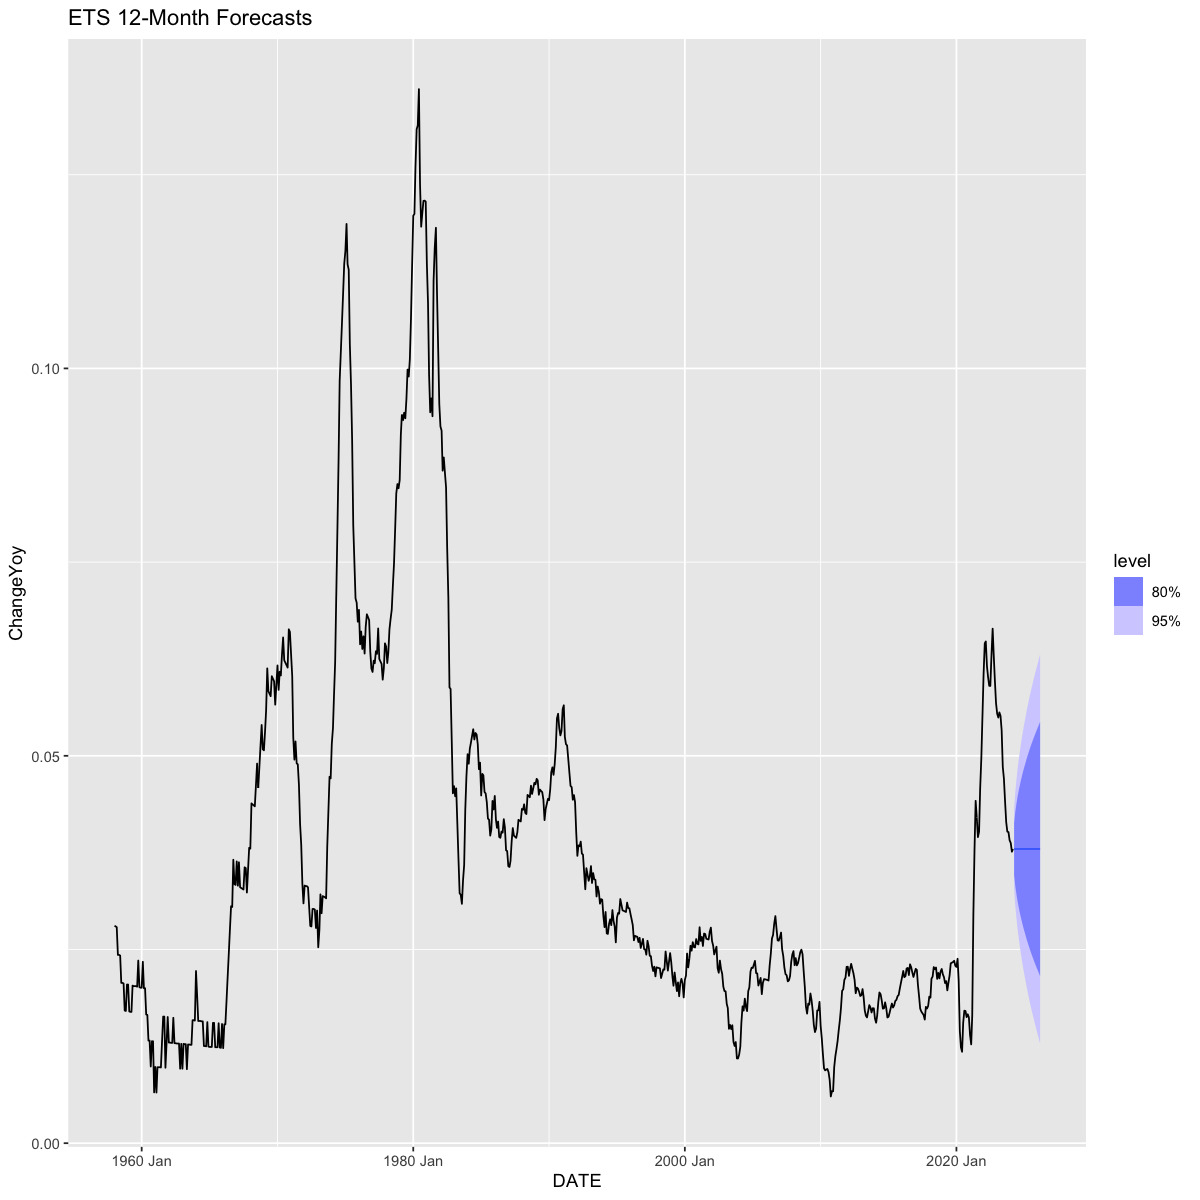

In [29]:
yoy %>% model(NAIVE(ChangeYoy)) %>% forecast(horizon=12) %>% autoplot(yoy) + labs(title='ETS 12-Month Forecasts')